In [1]:
# Import common python libraries
import numpy as np
import pandas as pd
import os

# Matplotlib for plotting figures
import matplotlib as mpl
import matplotlib.pyplot as plt

# Where to save the figures
EXERCISE_ROOT_DIR = "."
IMAGES_PATH = os.path.join(EXERCISE_ROOT_DIR, "images")

In [2]:
# The function allows images to be saved
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# load the preprocessed iris dataset
dataset = pd.read_csv('datasets/iris_process.data',
                      delimiter=',',
                      header=None, 
                      names=['sepal length', 'sepal width', 'petal length', 'petal width','class'])

print('\nNumber of records:',len(dataset))
print('\nclass domain:', dataset['class'].unique())
print('\n\n',dataset.head())


Number of records: 150

class domain: [0 1]


    sepal length  sepal width  petal length  petal width  class
0           5.1          3.5           1.4          0.2      0
1           4.9          3.0           1.4          0.2      0
2           4.7          3.2           1.3          0.2      0
3           4.6          3.1           1.5          0.2      0
4           5.0          3.6           1.4          0.2      0


In [4]:
X = pd.DataFrame(dataset,columns=['sepal length','sepal width']).values
y = dataset['class'].values

In [5]:
def plot_dataset(X,y):
    plt.scatter(X[y == 0, 0],X[y == 0, 1],
                s=50, c='lightgreen',
                marker='o', edgecolor='black',label='class 1')
    plt.scatter(X[y == 1, 0],X[y == 1, 1],
                s=50, c='orange',
                marker='v', edgecolor='black',
                label='class 2')
    plt.legend(scatterpoints=1)
    plt.tight_layout()
    plt.xlabel("sepal length", fontsize=14)
    plt.ylabel("sepal width", fontsize=14)
    plt.axis([4.0,8.5,2.0,4.5])

Saving figure NB_TR_DATASET


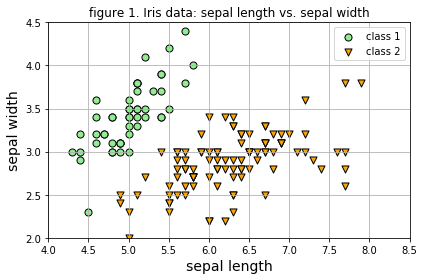

In [6]:
plt.figure(1)
plt.title('figure 1. Iris data: sepal length vs. sepal width')
plot_dataset(X,y)
plt.grid(True)
save_fig("NB_TR_DATASET")
plt.show()

In [7]:
def naiveBayes(X, y):
    parameters = []
    # Calculate the mean and variance of each feature for each class
    for c in np.unique(y):
        X_c = X[np.where(y == c)]
        mu = np.mean(X_c, axis= 0)
        prior = np.mean(y==c)
        var = np.var(X_c, axis= 0).T
        params = {"mean": mu, "var": var, "prior": prior}
        parameters.append(params)
    return parameters

In [8]:
parameters = naiveBayes(X, y)
print('\nclass 1 parameters:',parameters[0])
print('class 2 parameters:',parameters[1])
print('\nsigma 1:\n', np.diag(parameters[0]['var']))
print('sigma 2\n:', np.diag(parameters[1]['var']))


class 1 parameters: {'mean': array([5.006, 3.418]), 'var': array([0.121764, 0.142276]), 'prior': 0.3333333333333333}
class 2 parameters: {'mean': array([6.262, 2.872]), 'var': array([0.434956, 0.109616]), 'prior': 0.6666666666666666}

sigma 1:
 [[0.121764 0.      ]
 [0.       0.142276]]
sigma 2
: [[0.434956 0.      ]
 [0.       0.109616]]


In [9]:
def likelihood(X, mu, var):
    sigma = np.diag(var)
    sigma_sqrd_det = np.linalg.det(sigma)  
    sigma_sqrd_inv = np.linalg.pinv(sigma)  
    X_diff = X - mu
    eqn_part1 = 1/((2*np.pi)**(len(mu)/2.0) * sigma_sqrd_det**(0.5))
    eqn_part2 = np.exp(-0.5 * (X_diff.dot(sigma_sqrd_inv) * X_diff).sum(axis=1))
    return eqn_part1 * eqn_part2

In [10]:
test = [[6.75, 4.25]]
likelihood1 = likelihood(test, parameters[0]["mean"], parameters[0]["var"])
print('\nLikelihood for class 1:',likelihood1[0])
likelihood2 = likelihood(test, parameters[1]["mean"], parameters[1]["var"])
print('Likelihood for class 2:',likelihood2[0])


Likelihood for class 1: 3.998404853926953e-07
Likelihood for class 2: 9.596568862873222e-05


In [11]:
def density(parameters, n_classes):
    density_contour_params = []
    for i in n_classes:
        linespace = np.arange(0, 10, 0.05)
        xx, yy = np.meshgrid(linespace, linespace)
        Z = likelihood(np.c_[xx.ravel(), yy.ravel()],
                       parameters[i]['mean'],
                       parameters[i]['var']);
        Z = Z.reshape(xx.shape)
        dimension = {'x':xx, 'y':yy, 'z':Z}
        density_contour_params.append(dimension)
    return density_contour_params

Saving figure NB_DENSITY_CONTOURS


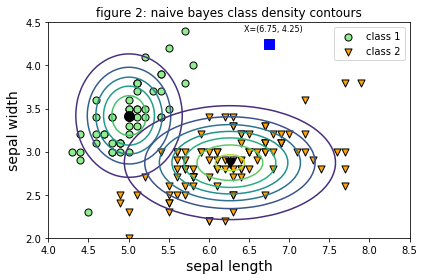

In [12]:
density_contour_params = density(parameters, np.unique(y))

x1 = density_contour_params[0]['x']
y1 = density_contour_params[0]['y']
z1 = density_contour_params[0]['z']

x2 = density_contour_params[1]['x']
y2 = density_contour_params[1]['y']
z2 = density_contour_params[1]['z']

plt.figure(2)
plt.title('figure 2: naive bayes class density contours')
plt.contour(x1,y1,z1)
plt.contour(x2,y2,z2)
plot_dataset(X,y)
plt.plot(6.75,4.25,'s', color='blue', markersize=10)
plt.plot(5.006, 3.418,'o', color='black', markersize=10)
plt.plot(6.262, 2.872,'v', color='black', markersize=10)
plt.axis([4,8.5, 2.0, 4.5])
plt.annotate("X=(6.75, 4.25)",
             xy=(6.78, 4.25),
             xytext=(6.8, 4.4),
             ha="center",
             fontsize=8,
            )
plt.grid(False)
save_fig("NB_DENSITY_CONTOURS")
plt.show()

In [13]:
def posterior(sample,parameters,n_classes):
    posteriors = []
    for i in n_classes:
        likelihood_prob = likelihood(sample, parameters[i]["mean"], parameters[i]["var"])
        posterior = likelihood_prob * parameters[i]['prior']
        posteriors.append(posterior)
    return posteriors

In [14]:
posteriors = posterior(test, parameters,np.unique(y))
print('\nThe posterior probability for class 1:',posteriors[0][0])
print('The posterior probability for class 2:',posteriors[1][0])


The posterior probability for class 1: 1.332801617975651e-07
The posterior probability for class 2: 6.397712575248815e-05


In [15]:
def classify(n_classes,posteriors):
    y_hat = n_classes[np.argmax(posteriors)]
    if y_hat == 0:
        print('class 1.')
    elif y_hat == 1:
        print('class 2.')

In [16]:
classify(np.unique(y),posteriors)

class 2.


### Reference book###
    1. Mohammed, J & Wagner, M (2014), Data mining and Analysis: Fundamental Concepts and Algorithms, p475 